

## Case study definition


Let's focus on the following function, defined for any complex number $z$:

$$ f_c: z \rightarrow \sqrt{z^2 + c} $$

With $c$ a complex number.

In [1]:
import numpy as np

def f(z, c):
    return np.sqrt(z**2 + c)
        

This function can be called recursively $n$ times:

$$ g_{c,n}: z \rightarrow f_c^n(z)=f_c(f_c(f_c(\ldots))) $$

In [2]:
def g(z, c, n):
    for _ in range(n):
        z = f(z, c)
    return z

$z$ is a complex number: a limited section of the complex plan is needed for evaluation of $g_{c,n}$.

In [3]:
x, y = np.meshgrid(np.linspace(-1, 1, 2000), np.linspace(-1, 1, 2000))
mesh = x + 1j * y   # imaginary part is defined using `j`

And here is a function that defines some values for `c`:

In [7]:

from numpy.random import uniform
def create_c_values(k):
    c_values = uniform(-1, 1, k) + 1j * uniform(-1, 1, k)
    return c_values

## Sequential version

The sequential version of a function that would evaluate `g` given some `c` values is presented here after:

In [5]:
def evaluate_sequential(mesh, c_values, n=50):
    for c in c_values:
        g(mesh, c, n)

### Some benchmarks

#### With respect to `n`

Let's observe the dependance of the total running time in `n` (number of evaluations of `f`):

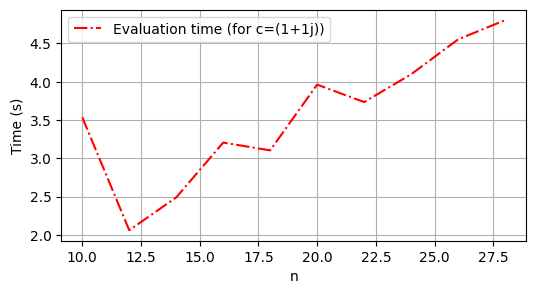

In [6]:
import matplotlib.pyplot as plt

n = range(10, 30, 2)
running_times = []
c = 1 + 1j
for k in n:
    timeit = %timeit -q -o g(mesh, c, k)
    running_times.append(timeit.average)
    
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(n, running_times, 'r-.', label=f'Evaluation time (for c={c})')
_ = ax.set_xlabel('n'), ax.set_ylabel('Time (s)'), ax.legend(), ax.grid()

The running time grows __linearly__ with `n`.



#### With respect to the number of `c` values


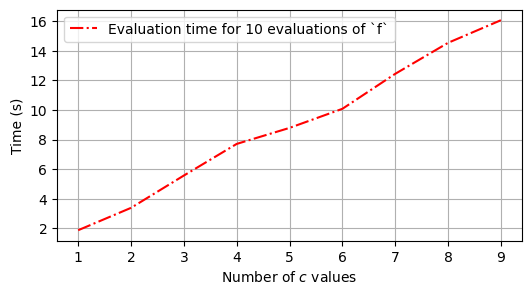

In [7]:
import matplotlib.pyplot as plt

running_times = []
n = 10
nbr_c_values = range(1, 10)
for k in nbr_c_values:
    c_values = create_c_values(k)
    timeit = %timeit -q -o evaluate_sequential(mesh, c_values, n=n)
    running_times.append(timeit.average)

    
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(nbr_c_values, running_times, 'r-.', label=f'Evaluation time for {n} evaluations of `f`')
_ = ax.set_xlabel('Number of $c$ values'), ax.set_ylabel('Time (s)'), ax.legend(), ax.grid()

same: solving twice more problems requires twice more time.



### Typical problem

Let's assume we need to run $g_{c,n}$ for 16 different $c$ values and $n=30$. 

In [8]:
c_values = create_c_values(16)
n = 30

How long does it take in a sequential mode?

In [9]:
%timeit evaluate_sequential(mesh, c_values, n=n)

1min 22s ± 4.92 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Multiprocessing version



### Code

Similarly to the threading case, `ProcessPoolExecutor` cab be used to manage multiprocessing easily.

The problem is split with respect to $c$ values: elements from the `c_values` variable are dealt with in parallel, with at most `max_workers` simultaneous running processes. This is possible since __no $c$ value is shared between 2 calls of `g`__.

In [9]:
from concurrent.futures import ProcessPoolExecutor

def evaluate_multiprocessing(c_values, n, max_workers=2):
    with ProcessPoolExecutor(max_workers=max_workers) as executor:        
        for c in c_values:
            executor.submit(g, mesh, c, n)        

Let's time the execution:

In [10]:
%timeit evaluate_multiprocessing(c_values, n)

51.1 s ± 2.45 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Notes

- Using __two simultaneous processes makes the resolution faster__ than in the sequential mode
- __Running time is not divided by 2__ because constant overhead times associated with the use of `ProcessPoolExecutor` are very large